In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import shap
import catboost as cb
shap.initjs()
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_pickle("master_DF_regress.pkl")
def relabel_cat(x):
    if type(x) == str:
        return "".join(x.split(" ")[-1].split("-"))
    else:
        return "NA"
df["group_status"] = df.cat.apply(relabel_cat)
df.CAP_Policy = df.CAP_Policy.apply(lambda x: "P"+str(x))

In [ ]:
df.iloc[:1000].to_csv("master_DF_regress_sample.csv")

In [54]:
def relabel_cong_pos(x):
    if x == "D":
        return -1
    elif x == "R":
        return 1
    else:
        return np.nan
df.cong_position = df.cong_position.apply(relabel_cong_pos)

In [55]:
def relabel_group_status(x):
    if x == "InGroup":
        return -1
    elif x == "OutGroup":
        return 1
    else:
        return 0
df.group_status = df.group_status.apply(relabel_group_status)

In [56]:
C = pd.read_pickle("master_DF.pkl")
CD = C[C.cong_position == "D"].sort_values("CAP_Policy")
CR = C[C.cong_position == "R"].sort_values("CAP_Policy")
CD = CD[CD.is_policy == 1]
CR = CR[CR.is_policy == 1]
X = CR.groupby("CAP_Policy")["weighted_pol"].count() - CD.groupby("CAP_Policy")["weighted_pol"].count()
id2diff = dict(zip(X.index, X.values))
df["CAP_diff"] = df.CAP_Policy.apply(lambda x: id2diff[ int(x[1:])] )

In [57]:
df["CAP_diff"]= df["CAP_diff"].astype(int)

In [59]:
R = df[df.cong_position == 1.0]
cols = ["is_policy", 
#         "CAP_Policy", 
        "Incivility", "group_status",
        "CAP_diff"
       ]
cat_cols = [
#     "CAP_Policy", 
    "group_status"]
for feature in cat_cols:
    df[feature] = pd.Series(df[feature], dtype="category")
X_R = R[cols ]
y_R = np.log10(R.Retweets.values+1)
X_train_R, X_test_R, y_train_R, y_test_R = train_test_split(X_R, y_R, test_size=0.20, random_state=314)

In [60]:
train_dataset = cb.Pool(X_train_R,y_train_R, cat_features=cat_cols)
test_dataset = cb.Pool(X_test_R,y_test_R, cat_features=cat_cols)
model_R = cb.CatBoostRegressor(loss_function='RMSE')

In [9]:
%%time
grid = {'iterations': [500],
        'learning_rate': [0.2],
        'depth': [8],
        'l2_leaf_reg': [0.2, ]}
model_R.grid_search(grid, train_dataset)

0:	learn: 0.8246206	test: 0.8255969	best: 0.8255969 (0)	total: 159ms	remaining: 1m 19s
1:	learn: 0.7556311	test: 0.7563959	best: 0.7563959 (1)	total: 231ms	remaining: 57.6s
2:	learn: 0.7055216	test: 0.7060548	best: 0.7060548 (2)	total: 313ms	remaining: 51.8s
3:	learn: 0.6709562	test: 0.6712567	best: 0.6712567 (3)	total: 441ms	remaining: 54.7s
4:	learn: 0.6478469	test: 0.6479268	best: 0.6479268 (4)	total: 527ms	remaining: 52.2s
5:	learn: 0.6329163	test: 0.6328294	best: 0.6328294 (5)	total: 611ms	remaining: 50.3s
6:	learn: 0.6222582	test: 0.6220104	best: 0.6220104 (6)	total: 709ms	remaining: 49.9s
7:	learn: 0.6161081	test: 0.6157587	best: 0.6157587 (7)	total: 752ms	remaining: 46.2s
8:	learn: 0.6111841	test: 0.6107393	best: 0.6107393 (8)	total: 847ms	remaining: 46.2s
9:	learn: 0.6084698	test: 0.6079549	best: 0.6079549 (9)	total: 942ms	remaining: 46.2s
10:	learn: 0.6063115	test: 0.6057506	best: 0.6057506 (10)	total: 1.07s	remaining: 47.5s
11:	learn: 0.6046653	test: 0.6041006	best: 0.604100

96:	learn: 0.5994338	test: 0.5999263	best: 0.5999263 (96)	total: 8.55s	remaining: 35.5s
97:	learn: 0.5994070	test: 0.5999170	best: 0.5999170 (97)	total: 8.62s	remaining: 35.4s
98:	learn: 0.5993940	test: 0.5999089	best: 0.5999089 (98)	total: 8.7s	remaining: 35.2s
99:	learn: 0.5993773	test: 0.5999145	best: 0.5999089 (98)	total: 8.79s	remaining: 35.2s
100:	learn: 0.5993672	test: 0.5999143	best: 0.5999089 (98)	total: 8.86s	remaining: 35s
101:	learn: 0.5993282	test: 0.5998889	best: 0.5998889 (101)	total: 8.93s	remaining: 34.8s
102:	learn: 0.5993048	test: 0.5998848	best: 0.5998848 (102)	total: 9.01s	remaining: 34.7s
103:	learn: 0.5992841	test: 0.5998754	best: 0.5998754 (103)	total: 9.09s	remaining: 34.6s
104:	learn: 0.5992599	test: 0.5998653	best: 0.5998653 (104)	total: 9.17s	remaining: 34.5s
105:	learn: 0.5992343	test: 0.5998626	best: 0.5998626 (105)	total: 9.26s	remaining: 34.4s
106:	learn: 0.5992267	test: 0.5998651	best: 0.5998626 (105)	total: 9.36s	remaining: 34.4s
107:	learn: 0.5992132	

189:	learn: 0.5980651	test: 0.5999643	best: 0.5998170 (122)	total: 16.1s	remaining: 26.3s
190:	learn: 0.5980460	test: 0.5999631	best: 0.5998170 (122)	total: 16.2s	remaining: 26.2s
191:	learn: 0.5980393	test: 0.5999618	best: 0.5998170 (122)	total: 16.3s	remaining: 26.1s
192:	learn: 0.5980282	test: 0.5999616	best: 0.5998170 (122)	total: 16.4s	remaining: 26s
193:	learn: 0.5980201	test: 0.5999589	best: 0.5998170 (122)	total: 16.4s	remaining: 25.9s
194:	learn: 0.5980002	test: 0.5999598	best: 0.5998170 (122)	total: 16.5s	remaining: 25.8s
195:	learn: 0.5979835	test: 0.5999556	best: 0.5998170 (122)	total: 16.6s	remaining: 25.8s
196:	learn: 0.5979739	test: 0.5999491	best: 0.5998170 (122)	total: 16.8s	remaining: 25.8s
197:	learn: 0.5979657	test: 0.5999554	best: 0.5998170 (122)	total: 16.8s	remaining: 25.7s
198:	learn: 0.5979635	test: 0.5999546	best: 0.5998170 (122)	total: 16.9s	remaining: 25.6s
199:	learn: 0.5979579	test: 0.5999536	best: 0.5998170 (122)	total: 17s	remaining: 25.6s
200:	learn: 0.

283:	learn: 0.5971470	test: 0.6000655	best: 0.5998170 (122)	total: 24s	remaining: 18.3s
284:	learn: 0.5971357	test: 0.6000647	best: 0.5998170 (122)	total: 24.1s	remaining: 18.2s
285:	learn: 0.5971264	test: 0.6000456	best: 0.5998170 (122)	total: 24.2s	remaining: 18.1s
286:	learn: 0.5971192	test: 0.6000418	best: 0.5998170 (122)	total: 24.3s	remaining: 18s
287:	learn: 0.5971128	test: 0.6000429	best: 0.5998170 (122)	total: 24.3s	remaining: 17.9s
288:	learn: 0.5971061	test: 0.6000426	best: 0.5998170 (122)	total: 24.4s	remaining: 17.8s
289:	learn: 0.5971017	test: 0.6000459	best: 0.5998170 (122)	total: 24.5s	remaining: 17.7s
290:	learn: 0.5970917	test: 0.6000468	best: 0.5998170 (122)	total: 24.6s	remaining: 17.6s
291:	learn: 0.5970846	test: 0.6000455	best: 0.5998170 (122)	total: 24.6s	remaining: 17.5s
292:	learn: 0.5970694	test: 0.6000410	best: 0.5998170 (122)	total: 24.7s	remaining: 17.5s
293:	learn: 0.5970594	test: 0.6000433	best: 0.5998170 (122)	total: 24.8s	remaining: 17.4s
294:	learn: 0.

376:	learn: 0.5964165	test: 0.6001699	best: 0.5998170 (122)	total: 32s	remaining: 10.4s
377:	learn: 0.5964118	test: 0.6001717	best: 0.5998170 (122)	total: 32.1s	remaining: 10.3s
378:	learn: 0.5963965	test: 0.6001751	best: 0.5998170 (122)	total: 32.1s	remaining: 10.3s
379:	learn: 0.5963823	test: 0.6001766	best: 0.5998170 (122)	total: 32.2s	remaining: 10.2s
380:	learn: 0.5963688	test: 0.6001674	best: 0.5998170 (122)	total: 32.3s	remaining: 10.1s
381:	learn: 0.5963530	test: 0.6001713	best: 0.5998170 (122)	total: 32.4s	remaining: 10s
382:	learn: 0.5963423	test: 0.6001740	best: 0.5998170 (122)	total: 32.5s	remaining: 9.94s
383:	learn: 0.5963354	test: 0.6001806	best: 0.5998170 (122)	total: 32.6s	remaining: 9.86s
384:	learn: 0.5963264	test: 0.6001827	best: 0.5998170 (122)	total: 32.8s	remaining: 9.78s
385:	learn: 0.5963156	test: 0.6001893	best: 0.5998170 (122)	total: 32.9s	remaining: 9.7s
386:	learn: 0.5963074	test: 0.6001953	best: 0.5998170 (122)	total: 32.9s	remaining: 9.62s
387:	learn: 0.5

469:	learn: 0.5955687	test: 0.6004260	best: 0.5998170 (122)	total: 41.2s	remaining: 2.63s
470:	learn: 0.5955656	test: 0.6004266	best: 0.5998170 (122)	total: 41.3s	remaining: 2.54s
471:	learn: 0.5955583	test: 0.6004284	best: 0.5998170 (122)	total: 41.4s	remaining: 2.45s
472:	learn: 0.5955491	test: 0.6004347	best: 0.5998170 (122)	total: 41.5s	remaining: 2.37s
473:	learn: 0.5955466	test: 0.6004339	best: 0.5998170 (122)	total: 41.6s	remaining: 2.28s
474:	learn: 0.5955392	test: 0.6004345	best: 0.5998170 (122)	total: 41.7s	remaining: 2.19s
475:	learn: 0.5955305	test: 0.6004339	best: 0.5998170 (122)	total: 41.8s	remaining: 2.11s
476:	learn: 0.5955273	test: 0.6004341	best: 0.5998170 (122)	total: 41.9s	remaining: 2.02s
477:	learn: 0.5955206	test: 0.6004312	best: 0.5998170 (122)	total: 42.1s	remaining: 1.94s
478:	learn: 0.5955180	test: 0.6004326	best: 0.5998170 (122)	total: 42.2s	remaining: 1.85s
479:	learn: 0.5955096	test: 0.6004325	best: 0.5998170 (122)	total: 42.4s	remaining: 1.77s
480:	learn

88:	learn: 0.5992480	test: 0.6006639	best: 0.6006635 (87)
89:	learn: 0.5992319	test: 0.6006661	best: 0.6006635 (87)
90:	learn: 0.5992160	test: 0.6006636	best: 0.6006635 (87)
91:	learn: 0.5992010	test: 0.6006576	best: 0.6006576 (91)
92:	learn: 0.5991839	test: 0.6006547	best: 0.6006547 (92)
93:	learn: 0.5991659	test: 0.6006600	best: 0.6006547 (92)
94:	learn: 0.5991505	test: 0.6006629	best: 0.6006547 (92)
95:	learn: 0.5991352	test: 0.6006642	best: 0.6006547 (92)
96:	learn: 0.5991059	test: 0.6006686	best: 0.6006547 (92)	total: 23.9s	remaining: 1m 39s
97:	learn: 0.5990900	test: 0.6006712	best: 0.6006547 (92)
98:	learn: 0.5990729	test: 0.6006672	best: 0.6006547 (92)
99:	learn: 0.5990559	test: 0.6006696	best: 0.6006547 (92)
100:	learn: 0.5990379	test: 0.6006682	best: 0.6006547 (92)
101:	learn: 0.5990133	test: 0.6006664	best: 0.6006547 (92)
102:	learn: 0.5989965	test: 0.6006681	best: 0.6006547 (92)	total: 25.2s	remaining: 1m 37s
103:	learn: 0.5989779	test: 0.6006652	best: 0.6006547 (92)
104:	l

222:	learn: 0.5971773	test: 0.6008239	best: 0.6006547 (92)
223:	learn: 0.5971628	test: 0.6008271	best: 0.6006547 (92)
224:	learn: 0.5971410	test: 0.6008324	best: 0.6006547 (92)
225:	learn: 0.5971254	test: 0.6008363	best: 0.6006547 (92)
226:	learn: 0.5971164	test: 0.6008408	best: 0.6006547 (92)	total: 55.4s	remaining: 1m 6s
227:	learn: 0.5971100	test: 0.6008421	best: 0.6006547 (92)
228:	learn: 0.5970973	test: 0.6008382	best: 0.6006547 (92)
229:	learn: 0.5970826	test: 0.6008430	best: 0.6006547 (92)
230:	learn: 0.5970704	test: 0.6008528	best: 0.6006547 (92)
231:	learn: 0.5970543	test: 0.6008499	best: 0.6006547 (92)	total: 56.8s	remaining: 1m 5s
232:	learn: 0.5970429	test: 0.6008536	best: 0.6006547 (92)
233:	learn: 0.5970340	test: 0.6008561	best: 0.6006547 (92)
234:	learn: 0.5970183	test: 0.6008599	best: 0.6006547 (92)
235:	learn: 0.5970030	test: 0.6008625	best: 0.6006547 (92)
236:	learn: 0.5969905	test: 0.6008526	best: 0.6006547 (92)
237:	learn: 0.5969803	test: 0.6008542	best: 0.6006547 (

356:	learn: 0.5956688	test: 0.6010874	best: 0.6006547 (92)
357:	learn: 0.5956622	test: 0.6010896	best: 0.6006547 (92)
358:	learn: 0.5956541	test: 0.6010941	best: 0.6006547 (92)
359:	learn: 0.5956431	test: 0.6010952	best: 0.6006547 (92)
360:	learn: 0.5956360	test: 0.6010958	best: 0.6006547 (92)	total: 1m 30s	remaining: 34.9s
361:	learn: 0.5956298	test: 0.6010964	best: 0.6006547 (92)
362:	learn: 0.5956208	test: 0.6011007	best: 0.6006547 (92)
363:	learn: 0.5956135	test: 0.6011034	best: 0.6006547 (92)
364:	learn: 0.5956053	test: 0.6011056	best: 0.6006547 (92)
365:	learn: 0.5955905	test: 0.6011093	best: 0.6006547 (92)	total: 1m 31s	remaining: 33.7s
366:	learn: 0.5955811	test: 0.6011146	best: 0.6006547 (92)
367:	learn: 0.5955717	test: 0.6011241	best: 0.6006547 (92)
368:	learn: 0.5955652	test: 0.6011250	best: 0.6006547 (92)
369:	learn: 0.5955543	test: 0.6011305	best: 0.6006547 (92)	total: 1m 33s	remaining: 32.7s
370:	learn: 0.5955431	test: 0.6011318	best: 0.6006547 (92)	total: 1m 33s	remainin

487:	learn: 0.5944437	test: 0.6014262	best: 0.6006547 (92)
488:	learn: 0.5944345	test: 0.6014284	best: 0.6006547 (92)
489:	learn: 0.5944275	test: 0.6014308	best: 0.6006547 (92)
490:	learn: 0.5944213	test: 0.6014342	best: 0.6006547 (92)
491:	learn: 0.5944091	test: 0.6014345	best: 0.6006547 (92)
492:	learn: 0.5943982	test: 0.6014378	best: 0.6006547 (92)
493:	learn: 0.5943925	test: 0.6014384	best: 0.6006547 (92)	total: 2m 2s	remaining: 1.49s
494:	learn: 0.5943830	test: 0.6014377	best: 0.6006547 (92)
495:	learn: 0.5943696	test: 0.6014370	best: 0.6006547 (92)
496:	learn: 0.5943603	test: 0.6014404	best: 0.6006547 (92)
497:	learn: 0.5943474	test: 0.6014424	best: 0.6006547 (92)	total: 2m 4s	remaining: 498ms
498:	learn: 0.5943400	test: 0.6014430	best: 0.6006547 (92)
499:	learn: 0.5943369	test: 0.6014458	best: 0.6006547 (92)	total: 2m 4s	remaining: 0us
CPU times: user 9min 2s, sys: 54.6 s, total: 9min 57s
Wall time: 3min 18s


{'params': {'depth': 8,
  'iterations': 500,
  'learning_rate': 0.2,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [32]:
pred_R = model_R.predict(X_test_R)
rmse = (np.sqrt(mean_squared_error(y_test_R, pred_R)))
r2 = r2_score(y_test_R, pred_R)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.60
R2: 0.08


In [24]:
%%time
shap_values_R = shap.TreeExplainer(model_R).shap_values(X_test_R)

CPU times: user 23.3 s, sys: 362 ms, total: 23.7 s
Wall time: 4.21 s


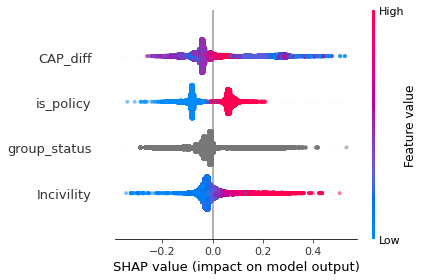

In [35]:
shap.summary_plot(shap_values_R, X_test_R, plot_size=(6,4), alpha = 0.5
#                   feature_names=["Is policy", "In-/Out-Group", "Incivility", "CAP Topic", "MC Position"],
             )

In [66]:
L = df[df.cong_position == -1.0]
cols = ["is_policy", 
#         "CAP_Policy", 
        "Incivility", "group_status",
        "CAP_diff"
       ]
cat_cols = [
#     "CAP_Policy",
    "group_status",]
for feature in cat_cols:
    df[feature] = pd.Series(df[feature], dtype="category")
X_L = L[cols]
y_L = np.log10(L.Retweets.values+1)
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(X_L, y_L, test_size=0.20, random_state=314)

In [67]:
train_dataset = cb.Pool(X_train_L,y_train_L, cat_features=cat_cols)
test_dataset = cb.Pool(X_test_L,y_test_L, cat_features=cat_cols)
model_L = cb.CatBoostRegressor(loss_function='RMSE')

In [68]:
%%time
grid = {'iterations': [500],
        'learning_rate': [0.1],
        'depth': [8],
        'l2_leaf_reg': [0.2, ]}
model_L.grid_search(grid, train_dataset)

0:	learn: 1.1560083	test: 1.1546939	best: 1.1546939 (0)	total: 72.1ms	remaining: 36s
1:	learn: 1.0884362	test: 1.0872845	best: 1.0872845 (1)	total: 131ms	remaining: 32.5s
2:	learn: 1.0310966	test: 1.0300397	best: 1.0300397 (2)	total: 163ms	remaining: 27s
3:	learn: 0.9816640	test: 0.9807229	best: 0.9807229 (3)	total: 196ms	remaining: 24.3s
4:	learn: 0.9391831	test: 0.9383419	best: 0.9383419 (4)	total: 256ms	remaining: 25.3s
5:	learn: 0.9032720	test: 0.9025332	best: 0.9025332 (5)	total: 310ms	remaining: 25.5s
6:	learn: 0.8715567	test: 0.8708207	best: 0.8708207 (6)	total: 365ms	remaining: 25.7s
7:	learn: 0.8447435	test: 0.8440559	best: 0.8440559 (7)	total: 401ms	remaining: 24.7s
8:	learn: 0.8220202	test: 0.8213603	best: 0.8213603 (8)	total: 449ms	remaining: 24.5s
9:	learn: 0.8033281	test: 0.8026640	best: 0.8026640 (9)	total: 495ms	remaining: 24.3s
10:	learn: 0.7882322	test: 0.7875764	best: 0.7875764 (10)	total: 534ms	remaining: 23.7s
11:	learn: 0.7752300	test: 0.7745850	best: 0.7745850 (1

99:	learn: 0.7120602	test: 0.7118795	best: 0.7118795 (99)	total: 5.14s	remaining: 20.6s
100:	learn: 0.7120467	test: 0.7118711	best: 0.7118711 (100)	total: 5.2s	remaining: 20.5s
101:	learn: 0.7120222	test: 0.7118520	best: 0.7118520 (101)	total: 5.25s	remaining: 20.5s
102:	learn: 0.7120051	test: 0.7118497	best: 0.7118497 (102)	total: 5.3s	remaining: 20.4s
103:	learn: 0.7119978	test: 0.7118472	best: 0.7118472 (103)	total: 5.34s	remaining: 20.3s
104:	learn: 0.7119823	test: 0.7118367	best: 0.7118367 (104)	total: 5.4s	remaining: 20.3s
105:	learn: 0.7119613	test: 0.7118181	best: 0.7118181 (105)	total: 5.44s	remaining: 20.2s
106:	learn: 0.7119505	test: 0.7118183	best: 0.7118181 (105)	total: 5.49s	remaining: 20.2s
107:	learn: 0.7119287	test: 0.7118116	best: 0.7118116 (107)	total: 5.53s	remaining: 20.1s
108:	learn: 0.7119176	test: 0.7118013	best: 0.7118013 (108)	total: 5.58s	remaining: 20s
109:	learn: 0.7119169	test: 0.7117996	best: 0.7117996 (109)	total: 5.59s	remaining: 19.8s
110:	learn: 0.711

191:	learn: 0.7108942	test: 0.7114850	best: 0.7114637 (184)	total: 9.7s	remaining: 15.6s
192:	learn: 0.7108787	test: 0.7114870	best: 0.7114637 (184)	total: 9.76s	remaining: 15.5s
193:	learn: 0.7108676	test: 0.7114878	best: 0.7114637 (184)	total: 9.79s	remaining: 15.4s
194:	learn: 0.7108606	test: 0.7114897	best: 0.7114637 (184)	total: 9.84s	remaining: 15.4s
195:	learn: 0.7108471	test: 0.7114876	best: 0.7114637 (184)	total: 9.9s	remaining: 15.4s
196:	learn: 0.7108401	test: 0.7114903	best: 0.7114637 (184)	total: 9.96s	remaining: 15.3s
197:	learn: 0.7108329	test: 0.7114896	best: 0.7114637 (184)	total: 10s	remaining: 15.3s
198:	learn: 0.7108231	test: 0.7114890	best: 0.7114637 (184)	total: 10.1s	remaining: 15.2s
199:	learn: 0.7108209	test: 0.7114883	best: 0.7114637 (184)	total: 10.1s	remaining: 15.1s
200:	learn: 0.7108150	test: 0.7114882	best: 0.7114637 (184)	total: 10.1s	remaining: 15.1s
201:	learn: 0.7108079	test: 0.7114821	best: 0.7114637 (184)	total: 10.2s	remaining: 15s
202:	learn: 0.71

287:	learn: 0.7100346	test: 0.7114450	best: 0.7114367 (275)	total: 14.8s	remaining: 10.9s
288:	learn: 0.7100297	test: 0.7114489	best: 0.7114367 (275)	total: 14.8s	remaining: 10.8s
289:	learn: 0.7100209	test: 0.7114547	best: 0.7114367 (275)	total: 14.9s	remaining: 10.8s
290:	learn: 0.7100158	test: 0.7114518	best: 0.7114367 (275)	total: 14.9s	remaining: 10.7s
291:	learn: 0.7100094	test: 0.7114513	best: 0.7114367 (275)	total: 14.9s	remaining: 10.6s
292:	learn: 0.7100046	test: 0.7114510	best: 0.7114367 (275)	total: 15s	remaining: 10.6s
293:	learn: 0.7099992	test: 0.7114472	best: 0.7114367 (275)	total: 15.1s	remaining: 10.6s
294:	learn: 0.7099925	test: 0.7114475	best: 0.7114367 (275)	total: 15.1s	remaining: 10.5s
295:	learn: 0.7099842	test: 0.7114531	best: 0.7114367 (275)	total: 15.2s	remaining: 10.4s
296:	learn: 0.7099723	test: 0.7114592	best: 0.7114367 (275)	total: 15.2s	remaining: 10.4s
297:	learn: 0.7099605	test: 0.7114612	best: 0.7114367 (275)	total: 15.3s	remaining: 10.3s
298:	learn: 

383:	learn: 0.7093429	test: 0.7115112	best: 0.7114367 (275)	total: 19.5s	remaining: 5.9s
384:	learn: 0.7093310	test: 0.7115148	best: 0.7114367 (275)	total: 19.6s	remaining: 5.85s
385:	learn: 0.7093222	test: 0.7115218	best: 0.7114367 (275)	total: 19.6s	remaining: 5.8s
386:	learn: 0.7093186	test: 0.7115209	best: 0.7114367 (275)	total: 19.7s	remaining: 5.74s
387:	learn: 0.7093148	test: 0.7115202	best: 0.7114367 (275)	total: 19.7s	remaining: 5.69s
388:	learn: 0.7093097	test: 0.7115215	best: 0.7114367 (275)	total: 19.8s	remaining: 5.64s
389:	learn: 0.7093003	test: 0.7115219	best: 0.7114367 (275)	total: 19.8s	remaining: 5.59s
390:	learn: 0.7092995	test: 0.7115231	best: 0.7114367 (275)	total: 19.9s	remaining: 5.54s
391:	learn: 0.7092970	test: 0.7115209	best: 0.7114367 (275)	total: 19.9s	remaining: 5.49s
392:	learn: 0.7092899	test: 0.7115264	best: 0.7114367 (275)	total: 20s	remaining: 5.43s
393:	learn: 0.7092887	test: 0.7115257	best: 0.7114367 (275)	total: 20s	remaining: 5.38s
394:	learn: 0.70

477:	learn: 0.7088090	test: 0.7116139	best: 0.7114367 (275)	total: 24.4s	remaining: 1.12s
478:	learn: 0.7088017	test: 0.7116175	best: 0.7114367 (275)	total: 24.5s	remaining: 1.07s
479:	learn: 0.7088005	test: 0.7116176	best: 0.7114367 (275)	total: 24.5s	remaining: 1.02s
480:	learn: 0.7087960	test: 0.7116217	best: 0.7114367 (275)	total: 24.5s	remaining: 970ms
481:	learn: 0.7087872	test: 0.7116235	best: 0.7114367 (275)	total: 24.6s	remaining: 918ms
482:	learn: 0.7087800	test: 0.7116282	best: 0.7114367 (275)	total: 24.6s	remaining: 867ms
483:	learn: 0.7087776	test: 0.7116288	best: 0.7114367 (275)	total: 24.7s	remaining: 816ms
484:	learn: 0.7087749	test: 0.7116293	best: 0.7114367 (275)	total: 24.7s	remaining: 765ms
485:	learn: 0.7087713	test: 0.7116281	best: 0.7114367 (275)	total: 24.8s	remaining: 713ms
486:	learn: 0.7087672	test: 0.7116300	best: 0.7114367 (275)	total: 24.8s	remaining: 663ms
487:	learn: 0.7087618	test: 0.7116269	best: 0.7114367 (275)	total: 24.9s	remaining: 612ms
488:	learn

103:	learn: 0.7118368	test: 0.7126137	best: 0.7126137 (103)
104:	learn: 0.7118288	test: 0.7126091	best: 0.7126091 (104)
105:	learn: 0.7118110	test: 0.7126055	best: 0.7126055 (105)
106:	learn: 0.7117961	test: 0.7125958	best: 0.7125958 (106)
107:	learn: 0.7117792	test: 0.7125820	best: 0.7125820 (107)
108:	learn: 0.7117740	test: 0.7125803	best: 0.7125803 (108)
109:	learn: 0.7117585	test: 0.7125742	best: 0.7125742 (109)
110:	learn: 0.7117446	test: 0.7125665	best: 0.7125665 (110)
111:	learn: 0.7117388	test: 0.7125650	best: 0.7125650 (111)
112:	learn: 0.7117284	test: 0.7125609	best: 0.7125609 (112)
113:	learn: 0.7117152	test: 0.7125500	best: 0.7125500 (113)
114:	learn: 0.7116978	test: 0.7125385	best: 0.7125385 (114)
115:	learn: 0.7116884	test: 0.7125379	best: 0.7125379 (115)	total: 16.1s	remaining: 53.2s
116:	learn: 0.7116757	test: 0.7125376	best: 0.7125376 (116)
117:	learn: 0.7116565	test: 0.7125271	best: 0.7125271 (117)
118:	learn: 0.7116442	test: 0.7125209	best: 0.7125209 (118)
119:	learn

235:	learn: 0.7101465	test: 0.7122124	best: 0.7122053 (221)
236:	learn: 0.7101309	test: 0.7122087	best: 0.7122053 (221)
237:	learn: 0.7101201	test: 0.7122083	best: 0.7122053 (221)
238:	learn: 0.7101114	test: 0.7122114	best: 0.7122053 (221)
239:	learn: 0.7100994	test: 0.7122107	best: 0.7122053 (221)
240:	learn: 0.7100888	test: 0.7122107	best: 0.7122053 (221)
241:	learn: 0.7100818	test: 0.7122098	best: 0.7122053 (221)
242:	learn: 0.7100722	test: 0.7122107	best: 0.7122053 (221)	total: 39.5s	remaining: 41.8s
243:	learn: 0.7100643	test: 0.7122105	best: 0.7122053 (221)
244:	learn: 0.7100539	test: 0.7122162	best: 0.7122053 (221)
245:	learn: 0.7100396	test: 0.7122141	best: 0.7122053 (221)
246:	learn: 0.7100328	test: 0.7122148	best: 0.7122053 (221)
247:	learn: 0.7100228	test: 0.7122145	best: 0.7122053 (221)
248:	learn: 0.7100067	test: 0.7122134	best: 0.7122053 (221)
249:	learn: 0.7099976	test: 0.7122120	best: 0.7122053 (221)
250:	learn: 0.7099903	test: 0.7122112	best: 0.7122053 (221)	total: 41s

365:	learn: 0.7090407	test: 0.7122747	best: 0.7122053 (221)
366:	learn: 0.7090344	test: 0.7122737	best: 0.7122053 (221)
367:	learn: 0.7090280	test: 0.7122735	best: 0.7122053 (221)
368:	learn: 0.7090206	test: 0.7122755	best: 0.7122053 (221)
369:	learn: 0.7090119	test: 0.7122771	best: 0.7122053 (221)
370:	learn: 0.7090036	test: 0.7122787	best: 0.7122053 (221)
371:	learn: 0.7089966	test: 0.7122796	best: 0.7122053 (221)
372:	learn: 0.7089939	test: 0.7122798	best: 0.7122053 (221)	total: 1m 3s	remaining: 21.7s
373:	learn: 0.7089894	test: 0.7122808	best: 0.7122053 (221)
374:	learn: 0.7089759	test: 0.7122829	best: 0.7122053 (221)
375:	learn: 0.7089661	test: 0.7122826	best: 0.7122053 (221)
376:	learn: 0.7089604	test: 0.7122829	best: 0.7122053 (221)
377:	learn: 0.7089532	test: 0.7122826	best: 0.7122053 (221)
378:	learn: 0.7089474	test: 0.7122829	best: 0.7122053 (221)
379:	learn: 0.7089417	test: 0.7122844	best: 0.7122053 (221)
380:	learn: 0.7089354	test: 0.7122849	best: 0.7122053 (221)	total: 1m 

498:	learn: 0.7081359	test: 0.7123466	best: 0.7122053 (221)
499:	learn: 0.7081300	test: 0.7123478	best: 0.7122053 (221)	total: 1m 27s	remaining: 0us
CPU times: user 8min 39s, sys: 1min, total: 9min 40s
Wall time: 2min 17s


{'params': {'depth': 8,
  'iterations': 500,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [69]:
%%time
shap_values_L = shap.TreeExplainer(model_L).shap_values(X_test_L)

CPU times: user 21.6 s, sys: 505 ms, total: 22.1 s
Wall time: 4.46 s


In [71]:
pred_L = model_L.predict(X_test_L)
rmse = (np.sqrt(mean_squared_error(y_test_L, pred_L)))
r2 = r2_score(y_test_L, pred_L)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.71
R2: 0.14


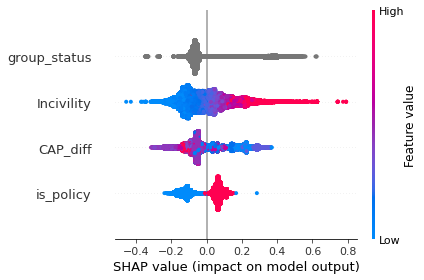

In [72]:
shap.summary_plot(shap_values_L, X_test_L, plot_size=(6,4),
#                   feature_names=["Is policy", "In-/Out-Group", "Incivility", "CAP Topic", "MC Position"],
             )